In [216]:
import torch
import torch.nn.functional as F
import math
import numpy as np
from torchvision import datasets, transforms
import torch.nn as nn
from functorch import make_functional, vmap, jacrev
import random

In [217]:
# Define 5-layer fully connected neural network with NTK parameterization

def _weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0, 1)


class FCNet(torch.nn.Module):
    def __init__(self, width):
        super(FCNet, self).__init__()
        self.width = width
        self.fc1 = nn.Linear(3072,width, bias=False)
        self.fc2 = nn.Linear(width,width, bias=False)
        self.fc3 = nn.Linear(width,width, bias=False)
        self.fc4 = nn.Linear(width,width, bias=False)
        self.fc5 = nn.Linear(width, 1, bias=False)
        self.apply(_weights_init)

    def forward(self, x):
        x = x.view(-1, 3072)       
        x = 1/math.sqrt(3072)*self.fc1(x)
        x = F.relu(x)
        x = 1/math.sqrt(self.width)*self.fc2(x)
        x = F.relu(x)
        x = 1/math.sqrt(self.width)*self.fc3(x)
        x = F.relu(x)
        x = 1/math.sqrt(self.width)*self.fc4(x)
        x = F.relu(x)
        x = 1/math.sqrt(self.width)*self.fc5(x)
        return x

In [218]:
# Set random seed

seed = 888
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda:0")

In [219]:
# Load CIFAR 10 dataset with class 7 and 9

Id = 6
train_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

        
trainset = datasets.CIFAR10(root='../../../cifar10', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='../../../cifar10', train=False, download=True, transform=transform)


idx = [i for i,x in enumerate(trainset.targets) if x == Id or x==Id+2]    
trainset.targets = [trainset.targets[i]-Id-1 for i in idx][0:train_size]
trainset.data = [trainset.data[i] for i in idx][0:train_size]

print("size of training set is : "+str(len(trainset.targets)))



train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=train_size, shuffle= False)  

Files already downloaded and verified
Files already downloaded and verified
size of training set is : 128


In [220]:
model = FCNet(width = 1024).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=9.0)

# Define functions (functorch) to compute NTK (Neural Tangent Kernel)

fnet, params = make_functional(model)
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2):
    # Compute J(x1)
    jac1 = torch.vmap(torch.func.jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]

    # Compute J(x2)
    jac2 = torch.vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]
    
    # Compute J(x1) @ J(x2).T
    result = torch.stack([torch.einsum('Naf,Mbf->NMab', j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result

In [221]:
epoch = 100
train_losses = []
top_5_losses = []
remaining_losses = []

In [222]:
for i in range(1,epoch+1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device).view(-1,1).float()
            output = model(data)
            optimizer.zero_grad()
            
            # Compute NTK and decompose the loss into the top eigendirections of NTK
            fnet, params = make_functional(model)
#             if i == 1:
            ntk = empirical_ntk_jacobian_contraction(fnet_single, params, data, data).squeeze(3).squeeze(2).detach()
            U,S,V = torch.svd(ntk)
            project = torch.abs((output-target).t()@U)**2/train_size
            top5 = torch.sum(project[0][:5])
            
            # Compute loss and do backpropogation
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            print(f'epoch:{i}, training loss:{loss.item()}')
            train_losses.append(loss.item())
            top_5_losses.append(top5.item())
            remaining_losses.append(loss.item()-top5.item())

epoch:1, training loss:1.0691490173339844
epoch:2, training loss:0.7497572898864746
epoch:3, training loss:0.8269569873809814
epoch:4, training loss:1.394374966621399
epoch:5, training loss:2.80180025100708
epoch:6, training loss:2.9508044719696045
epoch:7, training loss:1.118472933769226
epoch:8, training loss:0.41329243779182434
epoch:9, training loss:0.3613227605819702
epoch:10, training loss:0.32016193866729736
epoch:11, training loss:0.287110835313797
epoch:12, training loss:0.26023972034454346
epoch:13, training loss:0.23781847953796387
epoch:14, training loss:0.21874959766864777
epoch:15, training loss:0.2021932601928711
epoch:16, training loss:0.18756946921348572
epoch:17, training loss:0.17450132966041565
epoch:18, training loss:0.16274100542068481
epoch:19, training loss:0.15211789309978485
epoch:20, training loss:0.14245787262916565
epoch:21, training loss:0.13362017273902893
epoch:22, training loss:0.12554527819156647
epoch:23, training loss:0.11811725795269012
epoch:24, tr

In [223]:
import matplotlib.pyplot as plt

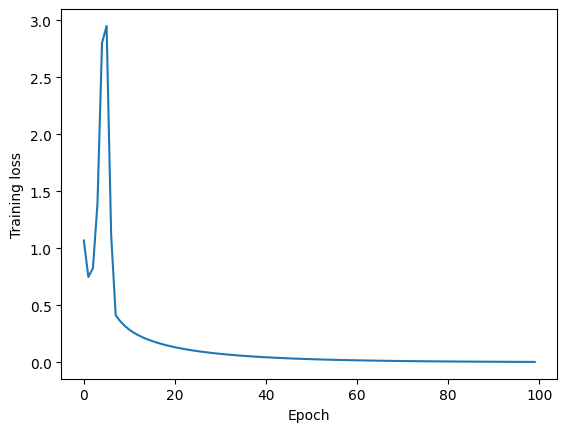

In [224]:
# Plot the total training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.show()

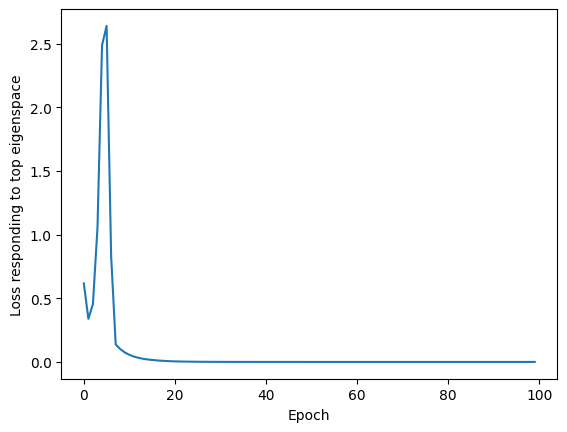

In [225]:
# Plot the loss corresponding to top-5 eigendirections of NTK
plt.plot(top_5_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss responding to top eigenspace')
plt.show()

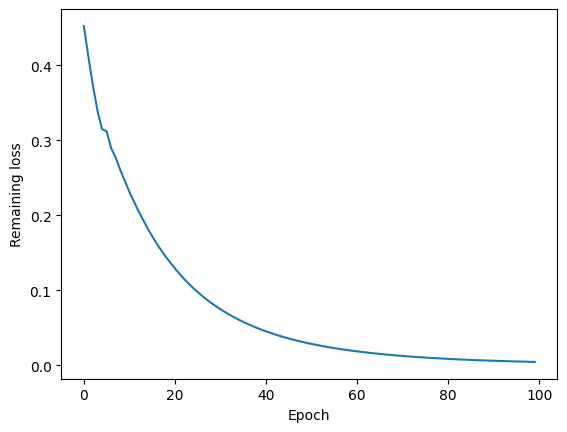

In [226]:
# Plot the loss corresponding to remaining (6th - ) eigendirections of NTK
plt.plot(remaining_losses)
plt.xlabel('Epoch')
plt.ylabel('Remaining loss')
plt.show()